# Big Data Engineering
## Exercise: Clustering Techniques on Student Survey Dataset
### Grupo: Sebastian Vieites, Alicia Avis y Claudia Benito

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext 
sc = SparkContext(master="local[4]")
print(sc)

<SparkContext master=local[4] appName=pyspark-shell>


In [2]:
import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
%pylab inline
# Just like using Spark requires having a SparkContext, using SQL requires an SQLContext
sqlContext = SQLContext(sc)
sqlContext

Populating the interactive namespace from numpy and matplotlib


## 0. Load data

In [3]:

data = 'turkiye-student-evaluation_generic.csv'
df = sqlContext.read.csv(data, header=True, inferSchema = True)


In [4]:
df.toPandas().head()

,instr,class,nb.repeat,attendance,difficulty,Q1,Q2,Q3,Q4,Q5,...,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28
0,1,2,1,0,4,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,1,2,1,1,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,1,2,1,2,4,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,1,2,1,1,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,1,2,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [5]:
df.printSchema()

root
 |-- instr: integer (nullable = true)
 |-- class: integer (nullable = true)
 |-- nb.repeat: integer (nullable = true)
 |-- attendance: integer (nullable = true)
 |-- difficulty: integer (nullable = true)
 |-- Q1: integer (nullable = true)
 |-- Q2: integer (nullable = true)
 |-- Q3: integer (nullable = true)
 |-- Q4: integer (nullable = true)
 |-- Q5: integer (nullable = true)
 |-- Q6: integer (nullable = true)
 |-- Q7: integer (nullable = true)
 |-- Q8: integer (nullable = true)
 |-- Q9: integer (nullable = true)
 |-- Q10: integer (nullable = true)
 |-- Q11: integer (nullable = true)
 |-- Q12: integer (nullable = true)
 |-- Q13: integer (nullable = true)
 |-- Q14: integer (nullable = true)
 |-- Q15: integer (nullable = true)
 |-- Q16: integer (nullable = true)
 |-- Q17: integer (nullable = true)
 |-- Q18: integer (nullable = true)
 |-- Q19: integer (nullable = true)
 |-- Q20: integer (nullable = true)
 |-- Q21: integer (nullable = true)
 |-- Q22: integer (nullable = true)
 |-- Q23

## 1. Data exploration
To use sql on a dataframe you need to first register it as a TempTable (Temporal Table in the memory).

In [6]:
df.registerTempTable('data')

### Number of instructors

In [7]:
num_instr = sqlContext.sql("SELECT instr FROM data GROUP BY instr") 
num_instr.show()


+-----+
|instr|
+-----+
|    1|
|    3|
|    2|
+-----+



### Number of responses per instructor

In [8]:
num_resp = sqlContext.sql("SELECT instr, COUNT(instr) AS num_resp FROM Data GROUP BY instr") #SELECT COUNT (DISTINT instr)
num_resp.show()

+-----+--------+
|instr|num_resp|
+-----+--------+
|    1|     775|
|    3|    3601|
|    2|    1444|
+-----+--------+



### Number of responses per class

In [9]:
sqlContext.sql("SELECT class, COUNT(class) AS num_resp FROM Data GROUP BY class").show()

+-----+--------+
|class|num_resp|
+-----+--------+
|   12|      41|
|    1|     303|
|   13|     841|
|    6|     558|
|    3|     904|
|    5|     656|
|    9|     571|
|    4|     187|
|    8|     500|
|    7|     187|
|   10|     448|
|   11|     484|
|    2|     140|
+-----+--------+



### Mean per question
Dos formas de hacer:

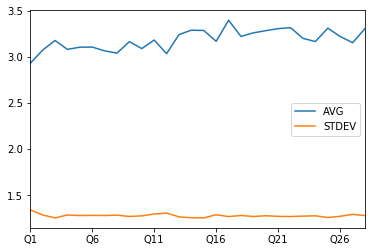

In [25]:
df.describe().toPandas()[[f'Q{i}' for i in range (1,29)]] \
.transpose() \
.rename(columns={1:'AVG',2:'STDEV'})[['AVG','STDEV']] \
.astype(float).plot()

In [27]:

for i in range (1,29):
    query = "SELECT mean(Q{}) AS Mean_resp_Q{} FROM Data".format(i,i)
    sqlContext.sql(query).show()

    

+------------------+
|      Mean_resp_Q1|
+------------------+
|2.9298969072164947|
+------------------+

+------------------+
|      Mean_resp_Q2|
+------------------+
|3.0738831615120277|
+------------------+

+-----------------+
|     Mean_resp_Q3|
+-----------------+
|3.178694158075601|
+-----------------+

+-----------------+
|     Mean_resp_Q4|
+-----------------+
|3.082474226804124|
+-----------------+

+------------------+
|      Mean_resp_Q5|
+------------------+
|3.1058419243986255|
+------------------+

+-----------------+
|     Mean_resp_Q6|
+-----------------+
|3.107388316151203|
+-----------------+

+-----------------+
|     Mean_resp_Q7|
+-----------------+
|3.066323024054983|
+-----------------+

+------------------+
|      Mean_resp_Q8|
+------------------+
|3.0419243986254294|
+------------------+

+-----------------+
|     Mean_resp_Q9|
+-----------------+
|3.165979381443299|
+-----------------+

+-----------------+
|    Mean_resp_Q10|
+-----------------+
|3.09072164

In [11]:
sqlContext.sql("SELECT COUNT(class) AS num_resp FROM Data GROUP BY class").show()

+--------+
|num_resp|
+--------+
|      41|
|     303|
|     841|
|     558|
|     904|
|     656|
|     571|
|     187|
|     500|
|     187|
|     448|
|     484|
|     140|
+--------+



## 2. Dimensionality reduction

In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
assembler = VectorAssembler(
             inputCols = ['Q{}'.format(i) for i in range (1,29)],
             outputCol = 'features') 
output = assembler.transform(df)

In [13]:
print(assembler.explainParams())

handleInvalid: How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip'). (default: error)
inputCols: input column names. (current: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28'])
outputCol: output column name. (default: VectorAssembler_4db58d5dc1f9__output, current: features)


In [14]:
#assembler.set('handleInvalid', df)

In [15]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors


pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(output)
result = model.transform(output).select("pcaFeatures")
result.toPandas()

,pcaFeatures
0,"[-15.870455768991269, -0.17700592299922246, -0..."
1,"[-15.870455768991269, -0.17700592299922246, -0..."
2,"[-26.45075961498545, -0.2950098716653624, -0.1..."
3,"[-15.870455768991269, -0.17700592299922246, -0..."
4,"[-5.29015192299709, -0.059001974333073665, -0...."
5,"[-21.16060769198836, -0.23600789733229466, -0...."
6,"[-21.16060769198836, -0.23600789733229466, -0...."
7,"[-26.45075961498545, -0.2950098716653624, -0.1..."
8,"[-21.347302516610487, -0.3465226999936847, 0.3..."
9,"[-21.16060769198836, -0.23600789733229466, -0...."


In [16]:
pca.setK(4)

PCA_018d53a057a0

In [30]:
pca.set(pca.getParams('k'),3) 
sc.close()

AttributeError: 'PCA' object has no attribute 'getParams'

## 3. Classification